In [4]:
import energyflow as ef
import numpy as np
import matplotlib.pyplot as plt

In [5]:
random_seed=0

In [12]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Charter"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = (
    r"\usepackage[bitstream-charter]{mathdesign} \usepackage{amsmath}" # \usepackage{siunitx}"
)

FONTSIZE = 20
FONTSIZE_LEGEND = FONTSIZE
FONTSIZE_TICK = FONTSIZE
TICKLABELSIZE = 10

colors = ["black", "#0343DE", "#A52A2A", "darkorange"]

In [7]:
data = ef.zjets_delphes.load("Pythia26", num_data=-1, pad=True, cache_dir='/remote/gpu04/petitjean/high-dim-unfolding/data/zplusjet',
                                       source='zenodo', which='all',
                                       include_keys=['mults'])

In [8]:
print(data['gen_mults'].min(), data['gen_mults'].max())
print(data['sim_mults'].min(), data['sim_mults'].max())
true_diff = data['gen_mults'] - data['sim_mults']
print(true_diff.min(), true_diff.max())

1 129
1 97
-38 67


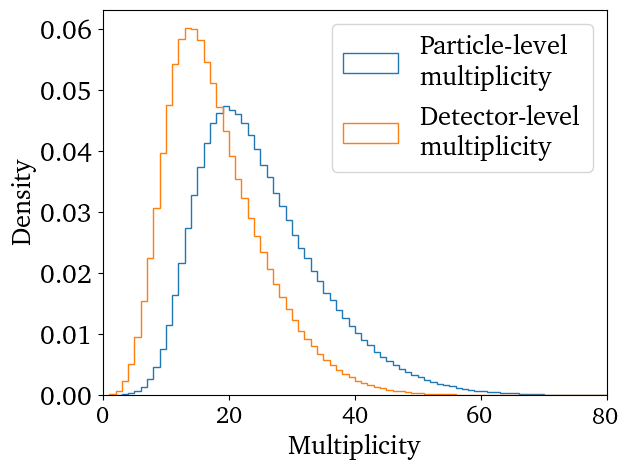

In [13]:
bins = np.arange(1,130)
plt.hist(data["gen_mults"], bins=bins, label='Particle-level\n multiplicity', histtype='step', density=True)
plt.hist(data["sim_mults"], bins=bins, label='Detector-level\n multiplicity', histtype='step', density=True)
plt.legend(fontsize=FONTSIZE_LEGEND)
plt.xlim(0,80)
#plt.xticks([1,152] + list(range(20,152,20)), fontsize=FONTSIZE-2)
plt.xticks(list(range(0,81,20)), fontsize=FONTSIZE-2)
plt.yticks(fontsize=FONTSIZE)
plt.xlabel('Multiplicity', fontsize=FONTSIZE)
plt.ylabel('Density', fontsize=FONTSIZE)
plt.tight_layout()
plt.show()
# plt.savefig('plots/hist_mult.pdf')

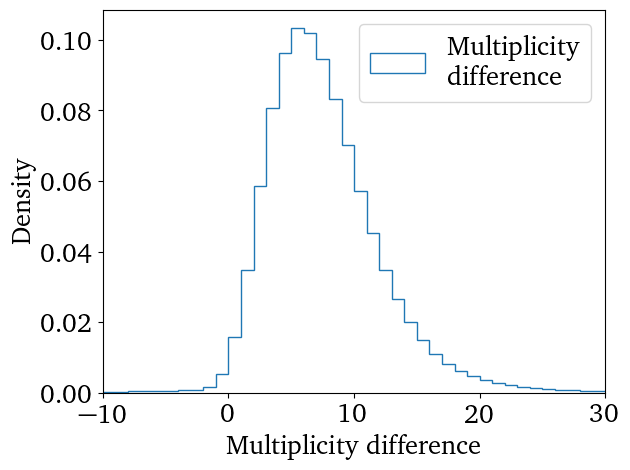

In [15]:
bins = np.arange(-38,68)
plt.hist(true_diff, bins=bins, label='Multiplicity\n difference', histtype='step', density=True)
plt.legend(fontsize=FONTSIZE_LEGEND, loc='upper right')
plt.yticks(fontsize=FONTSIZE_TICK)
plt.xlim(-10,30)
#plt.xticks([-53, 78] + list(range(-40,78,20)), fontsize=FONTSIZE_TICK)
plt.xticks(list(range(-10,31,10)), fontsize=FONTSIZE_TICK)
plt.xlabel('Multiplicity difference', fontsize=FONTSIZE)
plt.ylabel('Density', fontsize=FONTSIZE)
plt.tight_layout()
plt.show() 
# plt.savefig('plots/hist_mult_diff.pdf')

In [101]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Reshape true_diff to 2D array for GaussianMixture
X = data['gen_mults'].reshape(-1, 1)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=12)
gmm.fit(X)

GaussianMixture(n_components=3, random_state=12)

/tmp/ipykernel_3938883/3108407716.py:35: RuntimeWarning: divide by zero encountered in divide
  ratio = z / np.histogram(data['gen_mults'], bins=max(data['gen_mults']) - min(data['gen_mults']) + 1, density=True)[0]


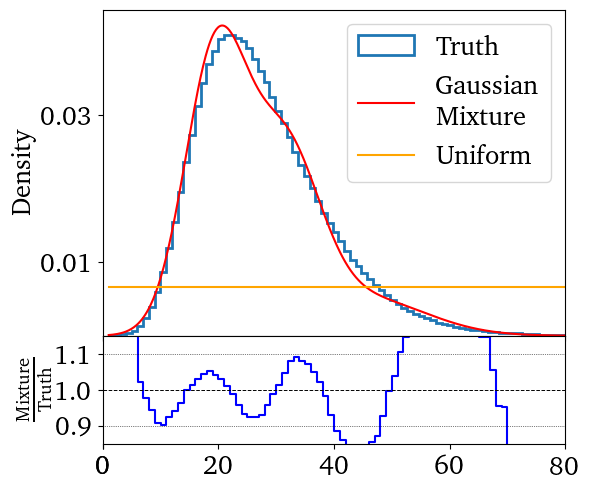

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Generate points for plotting the fitted distribution
x = np.linspace(min(data['gen_mults']), max(data['gen_mults']), 1000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))
x2 = np.arange(min(data['gen_mults']), max(data['gen_mults'])+1).reshape(-1, 1)
z = np.exp(gmm.score_samples(x2))

xrange = [0,80]

fig, axs = plt.subplots(
    2,
    1,
    sharex=True,
    figsize=(6, 5),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.00},
)
error_range=[0.85, 1.15]
error_ticks=[0.9, 1.0, 1.1]

# Top plot: histogram of true data and fitted mixture
axs[0].hist(data['gen_mults'], bins=max(data['gen_mults']) - min(data['gen_mults']) + 1, density=True, label='Truth', histtype='step', linewidth=2)
axs[0].plot(x, y, 'r-', label='Gaussian\nMixture', linewidth=1.5)
axs[0].plot((min(data['gen_mults']), max(data['gen_mults'])), (1/(max(data['gen_mults'])-min(data['gen_mults'])+1), 1/(max(data['gen_mults'])-min(data['gen_mults'])+1)), c='orange', label='Uniform')
#axs[0].set_xlabel('Multiplicity', fontsize=FONTSIZE)
axs[0].set_ylabel('Density', fontsize=FONTSIZE)
axs[0].set_yticks([0.01,0.03])
axs[0].set_xlim(*xrange)
#ax0.set_xticks([1] + list(range(20, 152, 20)))
axs[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axs[0].legend(fontsize=FONTSIZE_LEGEND)

ratio = z / np.histogram(data['gen_mults'], bins=max(data['gen_mults']) - min(data['gen_mults']) + 1, density=True)[0]
axs[1].step(x2, ratio, 'b-', linewidth=1.5)
axs[1].set_ylabel(
    r"$\frac{\mathrm{{Mixture}}}{\mathrm{Truth}}$", fontsize=FONTSIZE
)
axs[1].set_yticks(error_ticks)
axs[1].set_ylim(error_range)
axs[1].axhline(y=error_ticks[0], c="black", ls="dotted", lw=0.5)
axs[1].axhline(y=error_ticks[1], c="black", ls="--", lw=0.7)
axs[1].axhline(y=error_ticks[2], c="black", ls="dotted", lw=0.5)
axs[1].set_xticks(list(range(*xrange, 20)) + xrange)
axs[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

plt.tight_layout()
plt.savefig('plots/baseline_fit.pdf')


In [103]:
-gmm.score_samples(X).mean()

3.7566566580411855

In [104]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Reshape true_diff to 2D array for GaussianMixture
X = true_diff.reshape(-1, 1)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=12)
gmm.fit(X)

GaussianMixture(n_components=3, random_state=12)

/tmp/ipykernel_3938883/3014659951.py:30: RuntimeWarning: divide by zero encountered in divide
  ratio = z / np.histogram(true_diff, bins=max(true_diff) - min(true_diff) + 1, density=True)[0]


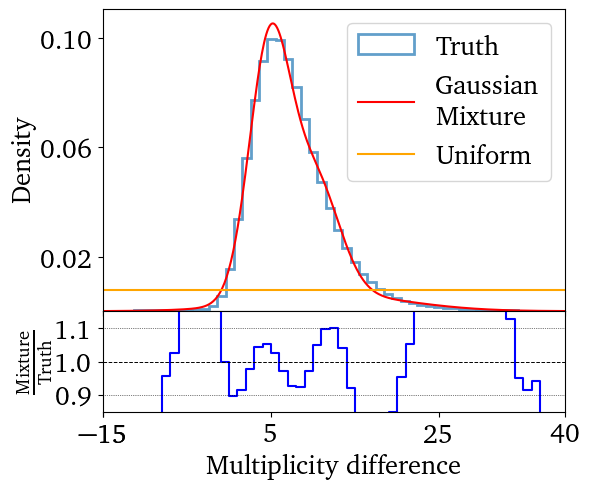

In [105]:
# Generate points for plotting the fitted distribution
x = np.linspace(min(true_diff), max(true_diff), 1000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))
x2 = np.arange(min(true_diff), max(true_diff)+1).reshape(-1, 1)
z = np.exp(gmm.score_samples(x2))

fig, axs = plt.subplots(
    2,
    1,
    sharex=True,
    figsize=(6, 5),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.00},
)

xrange = [-15,40]
error_range=[0.85, 1.15]
error_ticks=[0.9, 1.0, 1.1]

# Plot histogram of true data and fitted mixture
axs[0].hist(true_diff, bins=max(true_diff) - min(true_diff) + 1, density=True, alpha=0.7, label='Truth', histtype='step', linewidth=2)
axs[0].plot(x, y, 'r-', label='Gaussian\nMixture', linewidth=1.5)
axs[0].plot((min(true_diff),max(true_diff)), (1/(max(true_diff)-min(true_diff)+1), 1/(max(true_diff)-min(true_diff)+1)), c='orange', label='Uniform')
axs[0].set_ylabel('Density', fontsize=FONTSIZE)
axs[0].set_xlim(*xrange)
axs[0].set_xticks(xrange + list(range(*xrange,20)))
axs[0].set_yticks([0.02,0.06,0.1])
axs[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)
axs[0].legend(fontsize=FONTSIZE_LEGEND)

ratio = z / np.histogram(true_diff, bins=max(true_diff) - min(true_diff) + 1, density=True)[0]
axs[1].step(x2, ratio, 'b-', linewidth=1.5)
axs[1].set_xlabel('Multiplicity difference', fontsize=FONTSIZE)
axs[1].set_ylabel(
    r"$\frac{\mathrm{{Mixture}}}{\mathrm{Truth}}$", fontsize=FONTSIZE
)
axs[1].set_yticks(error_ticks)
axs[1].set_ylim(error_range)
axs[1].axhline(y=error_ticks[0], c="black", ls="dotted", lw=0.5)
axs[1].axhline(y=error_ticks[1], c="black", ls="--", lw=0.7)
axs[1].axhline(y=error_ticks[2], c="black", ls="dotted", lw=0.5)
axs[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

plt.tight_layout()
plt.savefig('plots/baseline_diff_fit.pdf')

In [106]:
results = -gmm.score_samples(X)

In [107]:
results.shape

(1686956,)

In [108]:
results.mean()

2.928100590254376

In [109]:
print(f"Mean: {np.mean(results)}")
print(f"Median: {np.median(results)}")
print(f"Std Dev: {np.std(results)}")
print(f"Min: {np.min(results)}")
print(f"Max: {np.max(results)}")
print(f"25th percentile: {np.percentile(results, 25)}")
print(f"75th percentile: {np.percentile(results, 75)}")

Mean: 2.928100590254376
Median: 2.5819822411960596
Std Dev: 0.9346043519144627
Min: 2.252594037606404
Max: 33.9170638691584
25th percentile: 2.345705222073803
75th percentile: 3.004127861675677


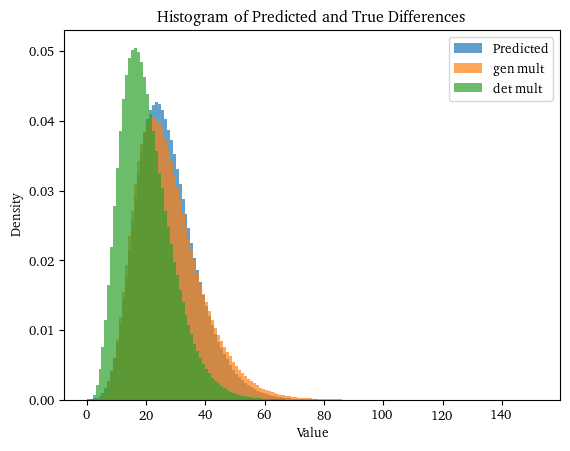

In [110]:
predicted_diff = gmm.sample(n_samples=len(true_diff))[0].flatten()
plt.hist(predicted_diff + data['sim_mults'], bins=np.arange(0,153), density=True, alpha=0.7, label='Predicted')
#plt.hist(predicted_diff, bins=np.arange(0,153), density=True, alpha=0.7, label='Predicted')
plt.hist(data['gen_mults'], bins=np.arange(0,153), density=True, alpha=0.7, label='gen mult')
plt.hist(data['sim_mults'], bins=np.arange(0,153), density=True, alpha=0.7, label='det mult')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted and True Differences')
plt.legend()
plt.show()

In [111]:
seed = np.random.randint(0, 1000)
# Reshape true_diff to 2D array for GaussianMixture
X = true_diff.reshape(-1, 1)
results = []
# Fit Gaussian Mixture Model
for i in range(5):
    gmm = GaussianMixture(n_components=10, random_state=seed+i)
    gmm.fit(X)
    results.append(-gmm.score_samples(X).mean())
    

In [112]:
print(results, np.mean(results), np.std(results))

[1.8248381389875472, 2.9270587146544518, 2.927306338663652, 2.9277676848533174, 2.9268320173479876] 2.706760578901391 0.44096132930001347
